In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurements = Base.classes.measurement

print(Base.classes.measurement)

print(measurements)
stations = Base.classes.station

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.measurement'>


In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
lastDate = session.query(measurements, measurements.date).order_by(measurements.date.desc()).first()

dateFromLast = dt.datetime.strptime(lastDate[1], '%Y-%m-%d')
yearFromLast = dateFromLast.year - 1

finalDate = dt.datetime(yearFromLast, dateFromLast.month, dateFromLast.day)

print(finalDate.date())

2016-08-23


In [12]:
last12MonthsData = session.query(measurements, measurements.date, measurements.prcp).filter(measurements.date >= finalDate.date())


In [13]:
resultSet = pd.read_sql(last12MonthsData.statement, session.bind)

In [14]:
print(resultSet.head())

     id      station        date  prcp  tobs
0  2364  USC00519397  2016-08-23  0.00  81.0
1  2365  USC00519397  2016-08-24  0.08  79.0
2  2366  USC00519397  2016-08-25  0.08  80.0
3  2367  USC00519397  2016-08-26  0.00  79.0
4  2368  USC00519397  2016-08-27  0.00  77.0


In [15]:
sortedFrame = resultSet.sort_values(by='date')

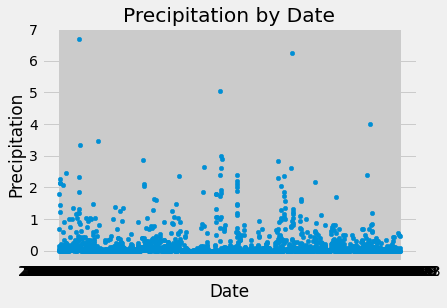

In [16]:
sortedFrame.plot(kind='scatter', x='date', y='prcp')
plt.title('Precipitation by Date')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

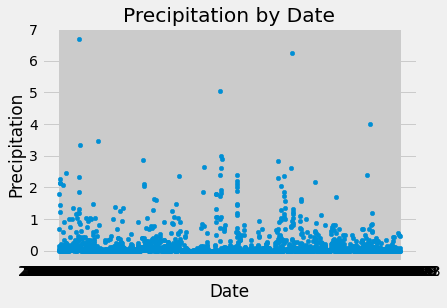

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastDate = session.query(measurements, measurements.date).order_by(measurements.date.desc()).first()

dateFromLast = dt.datetime.strptime(lastDate[1], '%Y-%m-%d')
yearFromLast = dateFromLast.year - 1

finalDate = dt.datetime(yearFromLast, dateFromLast.month, dateFromLast.day)
# Perform a query to retrieve the data and precipitation scores
last12MonthsData = session.query(measurements, measurements.date, measurements.prcp).filter(measurements.date >= finalDate.date())

# Save the query results as a Pandas DataFrame and set the index to the date column
resultSet = pd.read_sql(last12MonthsData.statement, session.bind)

# Sort the dataframe by date
sortedFrame = resultSet.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
sortedFrame.plot(kind='scatter', x='date', y='prcp')
plt.title('Precipitation by Date')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sortedFrame.describe()

,id,prcp,tobs
count,2230.000000,2021.000000,2230.000000
mean,10158.570404,0.177279,74.590583
std,5603.500203,0.461190,4.611667
min,2364.000000,0.000000,58.000000
25%,5287.250000,0.000000,72.000000
50%,8930.500000,0.020000,75.000000
75%,14750.750000,0.130000,78.000000
max,19550.000000,6.700000,87.000000


In [19]:
# Design a query to show how many stations are available in this dataset?
numberOfStations = sortedFrame['station'].unique()

print(numberOfStations)

['USC00519397' 'USC00517948' 'USC00519281' 'USC00514830' 'USC00513117'
 'USC00516128' 'USC00519523']


In [31]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
countOfstations = sortedFrame.station.mode()

print(countOfstations[0])

USC00519397


In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stationSubset = sortedFrame.loc[sortedFrame['station'] == countOfstations[0]]

lowestTemp = stationSubset['tobs'].min()
highestTemp = stationSubset['tobs'].max()
averageTemp = stationSubset['tobs'].mean()

NameError: name 'DateFormatter' is not defined

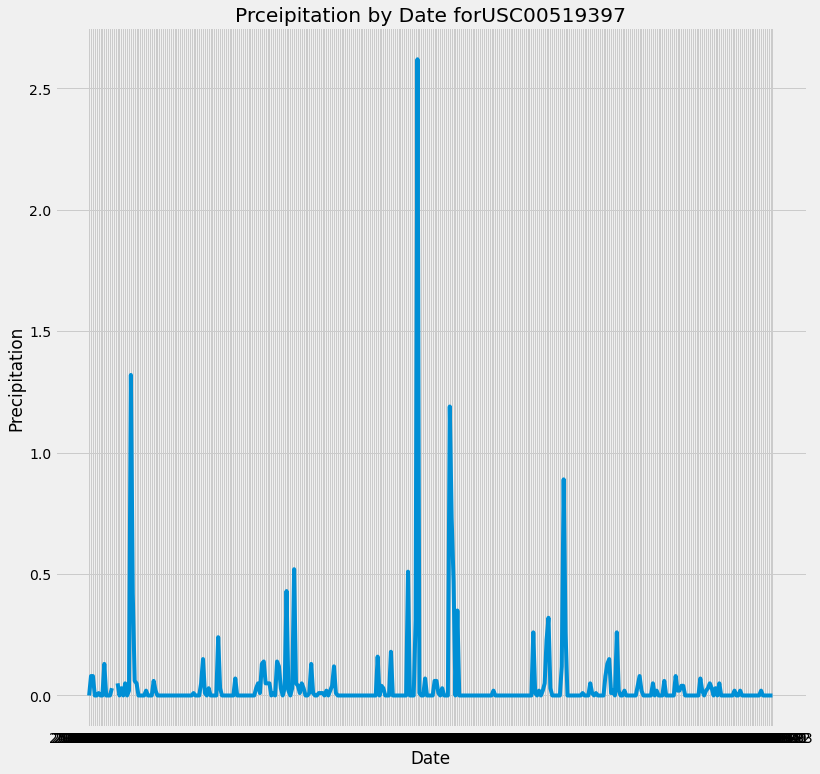

In [52]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stationWithTempObs = sortedFrame.groupby('station').count().sort_values(by='tobs', ascending=False)['tobs']

finalStation = stationWithTempObs.index[stationWithTempObs == stationWithTempObs[0]].tolist()[0]

stationSubset = sortedFrame.loc[sortedFrame['station'] == finalStation]

fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(stationSubset.date, stationSubset.prcp)
ax.set(xlabel="Date",
       ylabel="Precipitation",
       title="Prceipitation by Date for " + finalStation)
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
